Installation Packages

In [21]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pvlib
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP

Define position of solar panel

Link to understand how to use timestamp: http://pvlib-python.readthedocs.io/en/latest/timetimezones.html#finding-a-time-zone

Find the right latitude, longitude and time zone of Rueil Malmaison

In [22]:
import pytz
pytz.country_timezones('FR')

[u'Europe/Paris']

In [23]:
latitude, longitude, tz = 48.9, 2.2, 'Europe/Paris'

We want to forecast not in the US for a time horizon up to 4 days

In [24]:
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=4)
irrad_vars = ['ghi', 'dni', 'dhi']

We decide to use the NAM model

In [25]:
model = NAM()
data = model.get_processed_data(latitude, longitude, start, end)

data[irrad_vars].plot();
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NAM 20 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

HTTPError: Error accessing http://thredds.ucar.edu/thredds/ncss/grib/NCEP/NAM/CONUS_12km/conduit/Best?var=Low_cloud_cover_low_cloud&var=High_cloud_cover_high_cloud&var=Total_cloud_cover_entire_atmosphere_single_layer&var=Wind_speed_gust_surface&var=Medium_cloud_cover_middle_cloud&var=Temperature_surface&var=Downward_Short-Wave_Radiation_Flux_surface&time_start=2017-06-07T00%3A00%3A00%2B02%3A00&time_end=2017-06-11T00%3A00%3A00%2B02%3A00&latitude=48.9&longitude=2.2&vertCoord=100000&accept=netcdf: 400 Requested Lat/Lon Point (+48.9N 2.2E) is not contained in the Data. Data Bounding Box =  lat= [12.12,57.35] lon= [-152.98,-49.30]

Conclusion: is not contained in the Data. Data Bounding Box =  lat= [12.12,57.35] lon= [-152.98,-49.30] 
We will not be able to use NAM model
Action: we decide to use GFS model

We decide to use GFS

The Global Forecast System (GFS) is the US model that provides forecasts for the entire globe. The GFS is updated every 6 hours. The GFS is run at two resolutions, 0.25 deg and 0.5 deg, and is available with 3 hour time resolution. Forecasts from GFS model were shown above. Use the GFS, among others, if you want forecasts for 1-7 days or if you want forecasts for anywhere on Earth.

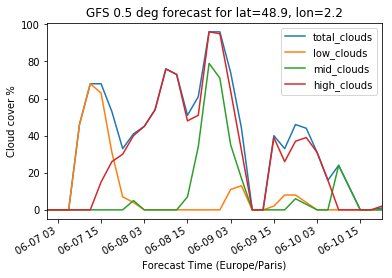

In [26]:
#choose the model
model = GFS()

#collect the processed data
data = model.get_processed_data(latitude, longitude, start, end)

#create an empty array with cloud variables
cloud_vars = ['total_clouds', 'low_clouds', 'mid_clouds', 'high_clouds']

#plot cloud variable
data[cloud_vars].plot();

#add legend
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

Conversion from cloud coverage to irradiance
2 methods: Clear Sky Scaling Algorithms, Liu-Jordan Cloud Cover
We will go for the Clear Sky Scaling Algorithms

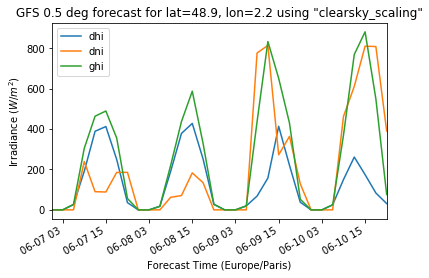

In [27]:
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot();
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

The irradiance forecasts have the same time resolution as the weather data. However, it is straightforward to interpolate the cloud cover forecasts onto a higher resolution time domain, and then recalculate the irradiance.
Consequently, we create a 5minute interpolation

/Users/basilebouquet/Documents/Python/PV_FX/lib/python2.7/site-packages/pvlib/irradiance.py:1151: RuntimeWarning: overflow encountered in exp
  delta_kn = a + b * np.exp(c*am)


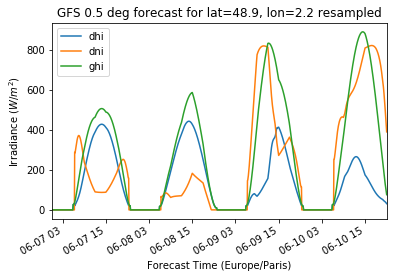

In [28]:
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot();
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude, longitude));
plt.legend();

Once we have the irradiance forecast, we can turn it now into a PV power forecast

In [29]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['SMA_America__SC630CP_US_315V__CEC_2012_']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module,inverter_parameters=inverter,modules_per_string=15,strings_per_inverter=300)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(fx_data.index, weather=fx_data);

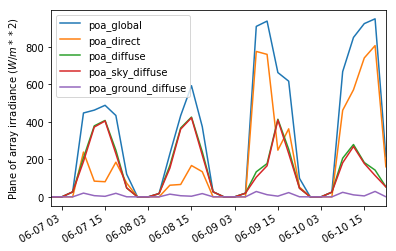

In [30]:
mc.total_irrad.plot();
plt.ylabel('Plane of array irradiance ($W/m**2$)');

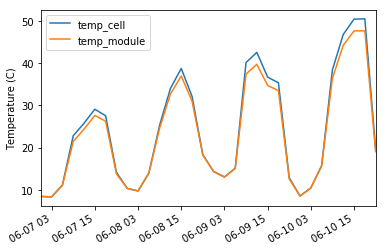

In [31]:
mc.temps.plot();
plt.ylabel('Temperature (C)');

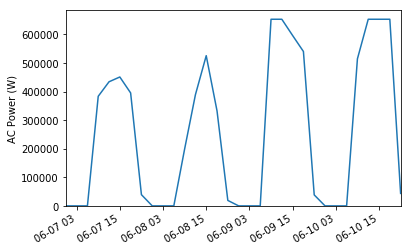

In [32]:
mc.ac.plot();
plt.ylim(0, None);    
plt.ylabel('AC Power (W)');